Обучение токенизации, векторизации текста. Слой Embedding. 

In [1]:
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import preprocessing as tfkp
from keras import layers as l
import numpy as np
import matplotlib.pyplot as plt

2023-04-29 13:57:05.495446: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
from keras.datasets import imdb

max_features = 10000
maxlen = 20

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

x_train = tfkp.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = tfkp.sequence.pad_sequences(x_test, maxlen=maxlen)

In [3]:
#@title Нейросеть со слоем Embedding
model = tfk.models.Sequential([
    l.Embedding(10000, 8, input_length=maxlen),
    l.Flatten(),
    l.Dense(1, activation='sigmoid')
])
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
model.summary()
hstr = model.fit(x_train,
                 y_train,
                 epochs=10,
                 batch_size=32,
                 validation_split=0.2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 8)             80000     
                                                                 
 flatten (Flatten)           (None, 160)               0         
                                                                 
 dense (Dense)               (None, 1)                 161       
                                                                 
Total params: 80,161
Trainable params: 80,161
Non-trainable params: 0
_________________________________________________________________


2023-04-29 13:57:16.171042: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-29 13:57:16.173380: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Epoch 1/10
625/625 [==============================] - 4s 5ms/step - loss: 0.6687 - acc: 0.6204 - val_loss: 0.6172 - val_acc: 0.6890
Epoch 2/10
625/625 [==============================] - 3s 4ms/step - loss: 0.5389 - acc: 0.7505 - val_loss: 0.5265 - val_acc: 0.7292
Epoch 3/10
625/625 [==============================] - 3s 4ms/step - loss: 0.4594 - acc: 0.7894 - val_loss: 0.5007 - val_acc: 0.7476
Epoch 4/10
625/625 [==============================] - 3s 4ms/step - loss: 0.4193 - acc: 0.8113 - val_loss: 0.4938 - val_acc: 0.7534
Epoch 5/10
625/625 [==============================] - 3s 4ms/step - loss: 0.3913 - acc: 0.8235 - val_loss: 0.4935 - val_acc: 0.7554
Epoch 6/10
625/625 [==============================] - 3s 5ms/step - loss: 0.3681 - acc: 0.8374 - val_loss: 0.4979 - val_acc: 0.7550
Epoch 7/10
625/625 [==============================] - 3s 5ms/step - loss: 0.3469 - acc: 0.8500 - val_loss: 0.5030 - val_acc: 0.7536
Epoch 8/10
625/625 [==============================] - 3s 4ms/step - loss: 0.

In [4]:
import os

imdb_dir = '/mnt/Linux_files/Datasets/aclImdb'
train_dir = os.path.join(imdb_dir, 'train')


In [5]:
labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else: 
                labels.append(1)

In [10]:
max_len = 100
training_samples = 200
validation_samples = 10000
max_words = 10000

tokenizer = tfkp.text.Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print(f'Найдено {len(word_index)} уникальных токенов.')
data = tfkp.sequence.pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Форма дата-тензора:', data.shape)
print('Форма бирка-тензора:', labels.shape)

indicies = np.arange(data.shape[0])
np.random.shuffle(indicies)
data = data[indicies]
labels = labels[indicies]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

Найдено 88582 уникальных токенов.
Форма дата-тензора: (25000, 20)
Форма бирка-тензора: (25000,)


In [11]:
glove_dir = '/mnt/Linux_files/Datasets/aclImdb/glove'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print(f'Найдено {len(embeddings_index)} слово-векторов.')

Найдено 400000 слово-векторов.


In [12]:
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [13]:
model = tfk.models.Sequential([
    l.Embedding(max_words, embedding_dim, input_length=maxlen),
    l.Flatten(),
    l.Dense(32, activation='relu'),
    l.Dense(1, activation='sigmoid')
])
model.summary()

model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(x_train,
                   y_train,
                   epochs=10,
                   batch_size=32,
                   validation_data=(x_val, y_val))

model.save_weights('pre_trained_glove_model.h5')

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 20, 100)           1000000   
                                                                 
 flatten_2 (Flatten)         (None, 2000)              0         
                                                                 
 dense_3 (Dense)             (None, 32)                64032     
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,064,065
Trainable params: 1,064,065
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
7/7 [==============================] - 7s 930ms/step - loss: 0.8263 - acc: 0.5400 - val_loss: 0.7456 - val_acc: 0.4988
Epoch 2/10
7/7 [==============================

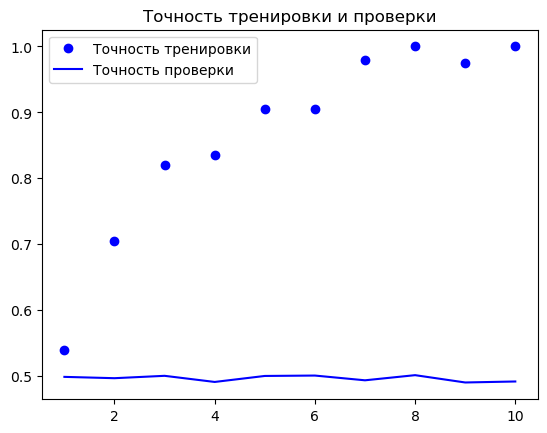

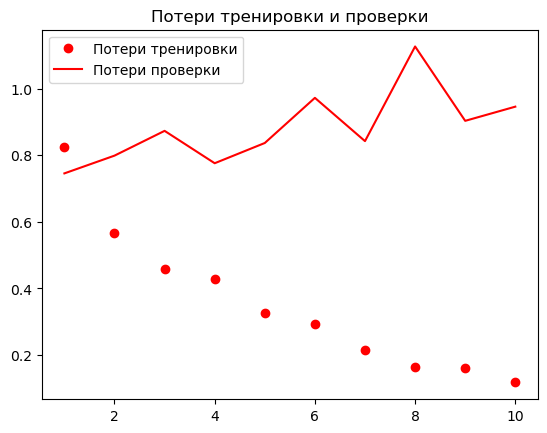

In [15]:
def show_res():
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, 'bo', label='Точность тренировки')
    plt.plot(epochs, val_acc, 'b', label='Точность проверки')
    plt.title('Точность тренировки и проверки')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'ro', label='Потери тренировки')
    plt.plot(epochs, val_loss, 'r', label='Потери проверки')
    plt.title('Потери тренировки и проверки')
    plt.legend()

    plt.show()

show_res()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 20, 100)           1000000   
                                                                 
 flatten_3 (Flatten)         (None, 2000)              0         
                                                                 
 dense_5 (Dense)             (None, 32)                64032     
                                                                 
 dense_6 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,064,065
Trainable params: 1,064,065
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
7/7 [==============================] - 4s 514ms/step - loss: 0.6951 - acc: 0.4550 - val_loss: 0.6934 - val_acc: 0.4996
Epoch 2/10
7/7 [==============================

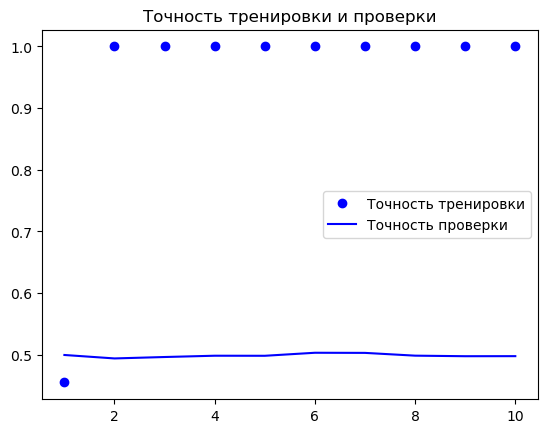

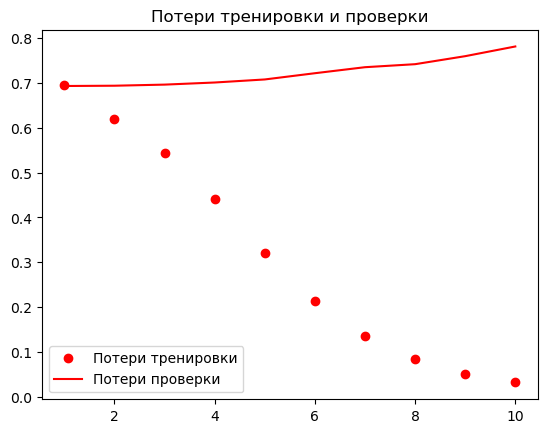

In [17]:
model = tfk.models.Sequential([
    l.Embedding(max_words, embedding_dim, input_length=maxlen),
    l.Flatten(),
    l.Dense(32, activation='relu'),
    l.Dense(1, activation='sigmoid')
])

model.summary()

model.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=['acc'])

history = model.fit(x_train,
                   y_train,
                   epochs=10,
                   batch_size=32,
                   validation_data=(x_val, y_val))

show_res()

In [20]:
test_dir = os.path.join(imdb_dir, 'test')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)
        
sequences = tokenizer.texts_to_sequences(texts)
x_test = tfkp.sequence.pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)

In [21]:
model.load_weights('pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)

782/782 [==============================] - 13s 17ms/step - loss: 0.9292 - acc: 0.4983


[0.9292294383049011, 0.4983200132846832]